In [ ]:
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import io

In [ ]:
from google.colab import drive, files
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def loadImages(dir):
  images = []
  for filename in os.listdir(dir):
    img = Image.open(os.path.join(dir, filename))
    img = img.resize((224,224))
    img = img.convert('RGB')
    img = np.array(img) / 255.0
    images.append(img)
  return images

In [ ]:
pneumonia = loadImages("/content/drive/MyDrive/ColabNotebooks/chest_xray/pnuemoia")
nonPneumonia = loadImages("/content/drive/MyDrive/ColabNotebooks/chest_xray/normal")

In [ ]:
def assignLabels(pneumonia, nonPneumonia):
  pneumoniaLabels = np.ones(len(pneumonia))
  normalLabels = np.zeros(len(nonPneumonia))
  return pneumoniaLabels, normalLabels

In [ ]:
pneumoniaLabels, nonPneumoniaLabels = assignLabels(pneumonia, nonPneumonia)

In [ ]:
data = pneumonia + nonPneumonia
labels = np.concatenate((pneumoniaLabels, nonPneumoniaLabels), axis=0)

# Splitting Data

In [ ]:
X = np.array(data)
y = np.array(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

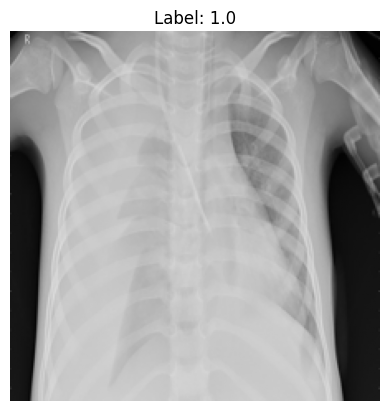

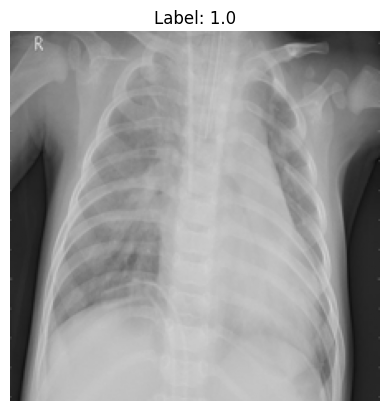

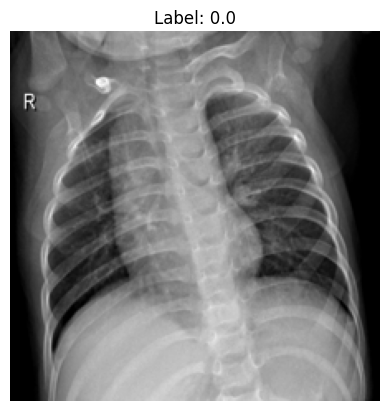

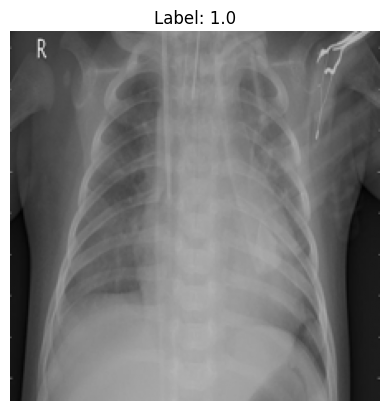

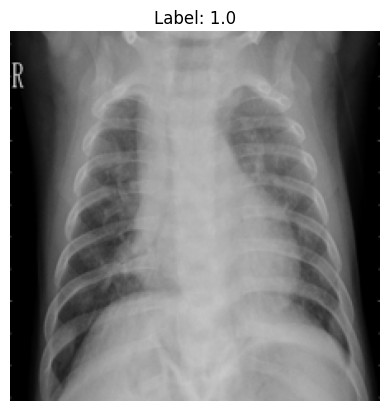

In [ ]:
for image, label, in train.take(5):
  plt.figure()
  plt.imshow(image.numpy())
  plt.title('Label: {}'. format(label.numpy()))
  plt.axis("off")
  plt.show()

In [ ]:
validation_size = int(0.1*202)
train = train.skip(validation_size)
val = train.take(validation_size)

In [ ]:
BATCH_SIZE = 32
train = train.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)

# CNN

In [ ]:
seqModel = Sequential()

seqModel.add(Conv2D(32, (3,3), activation = "relu", input_shape = (224,224,3), padding = "valid"))
seqModel.add(MaxPooling2D((2,2)))
seqModel.add(Flatten())
seqModel.add(Dense(256, activation = "relu"))
seqModel.add(Dropout(0.5))
seqModel.add(Dense(1, activation = "sigmoid"))

seqModel.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 394272)            0         
                                                                 
 dense_19 (Dense)            (None, 256)               100933888 
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 257       
                                                      

In [ ]:
seqModel.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
history = seqModel.fit(train, validation_data = val, epochs = 10, verbose = 1)

Epoch 1/10
16/16 [==============================] - 51s 3s/step - loss: 16.9816 - accuracy: 0.5477 - val_loss: 4.7799 - val_accuracy: 0.5000
Epoch 2/10
16/16 [==============================] - 48s 3s/step - loss: 2.0250 - accuracy: 0.5943 - val_loss: 0.4376 - val_accuracy: 0.8000
Epoch 3/10
16/16 [==============================] - 48s 3s/step - loss: 0.4053 - accuracy: 0.8357 - val_loss: 0.3261 - val_accuracy: 0.8500
Epoch 4/10
16/16 [==============================] - 50s 3s/step - loss: 0.3481 - accuracy: 0.8560 - val_loss: 0.3597 - val_accuracy: 0.8500
Epoch 5/10
16/16 [==============================] - 48s 3s/step - loss: 0.3273 - accuracy: 0.8803 - val_loss: 0.2906 - val_accuracy: 0.8500
Epoch 6/10
16/16 [==============================] - 48s 3s/step - loss: 0.2736 - accuracy: 0.8966 - val_loss: 0.1554 - val_accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 49s 3s/step - loss: 0.2245 - accuracy: 0.9209 - val_loss: 0.1868 - val_accuracy: 0.9000
Epoch 8/10
16/16 [=

In [ ]:
scores = seqModel.evaluate(test)

5/5 [==============================] - 4s 708ms/step - loss: 0.1685 - accuracy: 0.9380


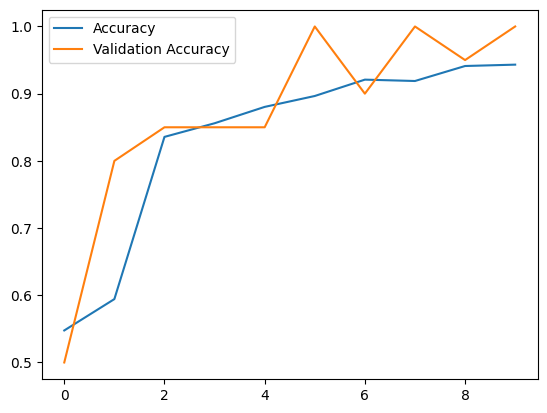

In [ ]:
plt.plot(history.history["accuracy"], label = "Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

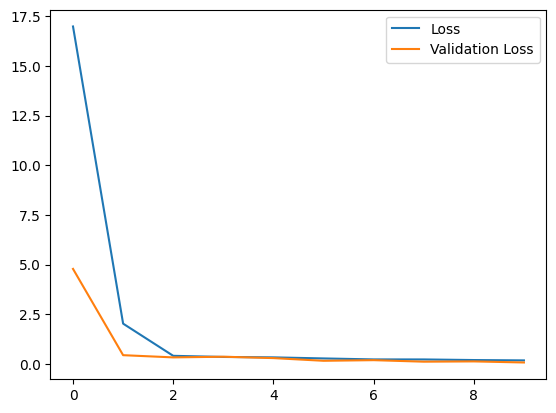

In [ ]:
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

In [ ]:
seqModel.save("/content/drive/MyDrive/ColabNotebooks/pneunomia2seq.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Test


In [ ]:
def load_uploaded_image(image_bytes):
  img = Image.open(io.BytesIO(image_bytes))
  img = img.resize((224,224))
  img = img.convert('RGB')
  img_array = np.array(img)
  img_array = img_array / 255.0
  return img_array

def predict_image(image_bytes):
  img_array = load_uploaded_image(image_bytes)
  img_array = np.expand_dims(img_array, axis = 0)
  prediction = seqModel.predict(img_array)
  if prediction[0][0] > 0.5:
    return "Pneunomia Detected"
  else:
    return "No Pneunomia Detected"

Saving person98_virus_182.jpeg to person98_virus_182.jpeg


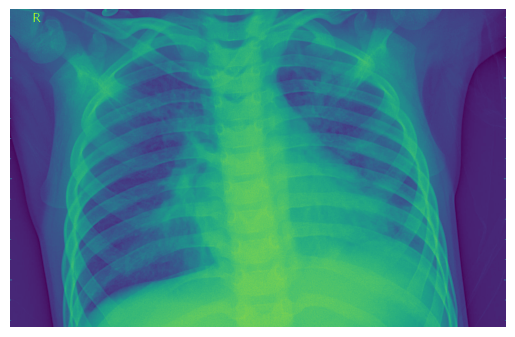

1/1 [==============================] - 0s 154ms/step
Pneunomia Detected


In [ ]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
image_bytes = uploaded[file_name]
img = Image.open(io.BytesIO(image_bytes))

plt.imshow(img)
plt.axis("off")
plt.show()

result = predict_image(image_bytes)
print(result)